# Project 2:  Predicting Iowa Housing Price with Linear Regression

--- 
# Notebook 04: Model Selection and Insights

---

Notebook Series:
1) EDA   
2) Data Cleaning 
3) Preprocessing and Feature Engineering
4) Model Selection and Insights (this notebook)

## Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [2]:
random_state = np.random.RandomState(42)

In [3]:
pd.set_option("display.max_columns", 250)

## Load Data

In [4]:
# import cleaned dataset
df_train = pd.read_csv('./datasets/train_cleaned_final.csv')

In [5]:
# import cleaned dataset and save IDs separately
df_test_ids = pd.read_csv('./datasets/test.csv')['Id']
df_test = pd.read_csv('./datasets/test_cleaned_final.csv')

## Model Preparation

### Train-Test Split & Scaling
Standardizing our data to avoid penalizing any features simply because of their scale. This also helps us to avoid penalizing the intercept, which would'nt make intuitive sense.

In [6]:
features = [col for col in df_train._get_numeric_data().columns if col != 'SalePrice']
features
X = df_train[features]
y = df_train['SalePrice'] 

In [7]:
# Use train_test_split function to split our x and y variables into a training set and holdout set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

In [8]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [9]:
# Step1: instantiate models
# Given that there's still multicollinearity in our data, 
# we're going to try out a few types of regularization alongside a standard linear regression model.
lr = LinearRegression()

In [10]:
ridge = RidgeCV(alphas=np.linspace(1, 200, 100))

In [11]:
lasso = LassoCV(n_alphas = 100)

In [12]:
# enet_alphas = np.arrange(0.5, 1.0, 0.005)
# enet_ratio = 0.5
enet = ElasticNetCV(alphas = np.arange(0.5, 1.0, 0.005), l1_ratio = 0.5, cv=5)

## OLS Model Summary

In [13]:
# ols fit
X_ols = sm.add_constant(X, prepend=True)
results = sm.OLS(y, X_ols).fit()

In [14]:
# OLS reults
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     166.6
Date:                Fri, 19 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:49:06   Log-Likelihood:                -23531.
No. Observations:                2049   AIC:                         4.730e+04
Df Residuals:                    1928   BIC:                         4.798e+04
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.701e+05   1.02e+05     -4.620      0.000    -6.7e+05   -2.71e+05
Lot Frontage             115.5239     38.415      3.007      0.003      40.184     190.864
Lot Shape               -653.5798   1368.340     -0.478      0.633   -3337.161    2030.002
Land Slope              5735.7025   3342.268      1.716      0.086    -819.138    1.23e+04
Overall Qual            8034.2881    824.331      9.746      0.000    6417.613    9650.963
Overall Cond            5043.1449    673.802      7.485      0.000    3721.688    6364.602
Year Built               274.0582     64.366      4.258      0.000     147.825     400.292
Exter Qual              8433.9060   1765.624      4.777      0.000    4971.174    1.19e+04
Exter Cond              -612.2754   1700.108     -0.360      0.719   -3946.519    2721.968
Bsmt Qual               3878.8469    827.354      4.688      0.000    2256.244    5501.449
Bsmt Cond              -2962.3277   2458.431     -1.205      0.228   -7783.790    1859.134
Bsmt Exposure           5818.8909    705.002      8.254      0.000    4436.244    7201.537
BsmtFin Type 1          3047.0299    642.908      4.739      0.000    1786.161    4307.899
BsmtFin Type 2           903.8192   1246.572      0.725      0.469   -1540.953    3348.591
Heating QC              1070.6553    787.014      1.360      0.174    -472.833    2614.144
Electrical             -4821.0498   3429.298     -1.406      0.160   -1.15e+04    1904.473
Gr Liv Area               69.6280      3.013     23.107      0.000      63.718      75.538
Bsmt Full Bath          9841.0919   1466.870      6.709      0.000    6964.273    1.27e+04
Bsmt Half Bath          2650.0617   2389.170      1.109      0.267   -2035.567    7335.691
Full Bath               1190.3257   1744.550      0.682      0.495   -2231.077    4611.728
Half Bath               3198.0718   1696.088      1.886      0.060    -128.288    6524.432
Bedroom AbvGr          -4744.8870   1092.982     -4.341      0.000   -6888.438   -2601.336
Kitchen AbvGr          -1.339e+04   5201.572     -2.574      0.010   -2.36e+04   -3188.401
Kitchen Qual            8452.6381   1188.247      7.114      0.000    6122.253    1.08e+04
TotRms AbvGrd            934.1791    770.928      1.212      0.226    -577.762    2446.120
Functional              6237.2926    920.717      6.774      0.000    4431.586    8042.999
Fireplaces              7667.5141   1872.011      4.096      0.000    3996.136    1.13e+04
Fireplace Qu            -868.7168    678.203     -1.281      0.200   -2198.805     461.372
Garage Cars             6613.4799   1297.889      5.096      0.000    4068.067    9158.893
Paved Drive             2591.1715   2635.423      0.983      0.326   -2577.407    7759.750
Pool QC                -2472.1945   3559.395     -0.695      0.487   -9452.863  

## Model Evaluation

### Cross Validation
Evaluate with *cross_val_score*

In [15]:
# Test first linearRegression model on unseen data
lr_cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print('R2 :', lr_cv_scores.mean())
lr_cv_mse_scores = -cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print('RMSE :', np.sqrt(lr_cv_mse_scores.mean()))

R2 : 0.8878109757310746
RMSE : 26409.26630454318


In [16]:
# Test ridge model on unseen data
ridge_cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5)
print('R2 :', ridge_cv_scores.mean())
ridge_cv_mse_scores = -cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print('RMSE :', np.sqrt(ridge_cv_mse_scores.mean()))

R2 : 0.8895172395228602
RMSE : 26196.543386575035


In [17]:
# Test lasso model on unseen data
lasso_cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5)
print('R2 :', lasso_cv_scores.mean())
lasso_cv_mse_scores = -cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print('RMSE :', np.sqrt(lasso_cv_mse_scores.mean()))

R2 : 0.890195403838506
RMSE : 26136.675967355295


In [18]:
# Test elasticnet model on unseen data
enet_cv_scores = cross_val_score(enet, X_train_scaled, y_train, cv=5)
print('R2 :', enet_cv_scores.mean())
enet_cv_mse_scores = -cross_val_score(enet, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print('RMSE :', np.sqrt(enet_cv_mse_scores.mean()))

R2 : 0.8839559539092491
RMSE : 26858.755842466348


We can see that all regularization are in factdoing better than our vanilla linear regression model. Seems that our Lasso model is performing slightly better so far, with *R2 of 0.89* and *RMSE of 26136*.

### Standard Linear Regression

In [19]:
lr.fit(X_train_scaled,y_train)

print("Training set R2(LR): " + str(lr.score(X_train_scaled,y_train)))
print("Testing set R2(LR): " + str(lr.score(X_test_scaled,y_test)))
print("CV scores on Training set R2(LR): " + str(lr_cv_scores.mean()))

Training set R2(LR): 0.9114095491487553
Testing set R2(LR): 0.9059328431692569
CV scores on Training set R2(LR): 0.8878109757310746


In [20]:
print("Training set RMSE(LR): " + str(np.sqrt(mean_squared_error(y_train, lr.predict(X_train_scaled)))))
print("Testing set RMSE(LR): " + str(np.sqrt(mean_squared_error(y_test,lr.predict(X_test_scaled)))))
print("CV scores on Training set RMSE(LR): " + str(np.sqrt(lr_cv_mse_scores.mean())))

Training set RMSE(LR): 23572.569102287795
Testing set RMSE(LR): 24386.540180696258
CV scores on Training set RMSE(LR): 26409.26630454318


Our observation on CV scores (0.888) are close to testing set scores(0.906), which is good. RMSE (test) is about 24386.

We can see that our model is slightly overfitting, as our accuracy has decreased between our training dataset and cross-validation dataset.

### Ridge Regression

In [21]:
ridge.fit(X_train_scaled,y_train);

In [22]:
# Optimal ridge alpha
best_ridge_alpha = ridge.alpha_
best_ridge_alpha

43.21212121212121

In [23]:
# create new ridge model with optimal alpha and fit to training data
ridge = Ridge(alpha = best_ridge_alpha)
ridge.fit(X_train_scaled, y_train);

In [24]:
# Test new ridge model on unseen data
ridge_cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5)
ridge_cv_mse_scores = -cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

In [25]:
print("Training set R2(Ridge): " + str(ridge.score(X_train_scaled,y_train)))
print("Testing set R2(Ridge): " + str(ridge.score(X_test_scaled,y_test)))
print("CV scores on Training set R2(Ridge): " + str(ridge_cv_scores.mean()))

Training set R2(Ridge): 0.910097352495997
Testing set R2(Ridge): 0.9045623067235455
CV scores on Training set R2(Ridge): 0.8896668820221054


In [26]:
print("Training set RMSE(Ridge): " + str(np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_scaled)))))
print("Testing set RMSE(Ridge): " + str(np.sqrt(mean_squared_error(y_test,ridge.predict(X_test_scaled)))))
print("CV scores on Training set RMSE(Ridge): " + str(np.sqrt(ridge_cv_mse_scores.mean())))

Training set RMSE(Ridge): 23746.505154675895
Testing set RMSE(Ridge): 24563.550850917152
CV scores on Training set RMSE(Ridge): 26182.508208985004


Cross Validation R2 score (0.890) is very close to Test score (0.910). RMSE (test) is about 24563.

Our model is still slightly overfitting, but ridge regression returns better results than Standard Linear Regression model.

### Lasso Regression

In [27]:
# fit lassoCV model
lasso.fit(X_train_scaled,y_train);

In [28]:
# Geenrate best alpha
best_lasso_alpha = lasso.alpha_
best_lasso_alpha

294.3665111484548

In [29]:
# create new lasso model with best alpha and fit to training data
lasso = Lasso(alpha = best_lasso_alpha)
lasso.fit(X_train_scaled, y_train);

In [30]:
# Test new lasso model on unseen data
lasso_cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5)
lasso_cv_mse_scores = -cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

In [31]:
print("Training set R2(Lasso): " + str(lasso.score(X_train_scaled,y_train)))
print("Testing set R2(Lasso): " + str(lasso.score(X_test_scaled,y_test)))
print("CV scores on Training set R2(Lasso): " + str(lasso_cv_scores.mean()))

Training set R2(Lasso): 0.9079035491131668
Testing set R2(Lasso): 0.9046157634304979
CV scores on Training set R2(Lasso): 0.8907133036876607


In [32]:
print("Training set RMSE(Lasso): " + str(np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_scaled)))))
print("Testing set RMSE(Lasso): " + str(np.sqrt(mean_squared_error(y_test,lasso.predict(X_test_scaled)))))
print("CV scores on Training set RMSE(Lasso): " + str(np.sqrt(lasso_cv_mse_scores.mean())))

Training set RMSE(Lasso): 24034.489868079247
Testing set RMSE(Lasso): 24556.6706004732
CV scores on Training set RMSE(Lasso): 26070.509311463706


Cross Validation R2 score (0.891) is very close to Test score (0.908). RMSE (test) is about 24556.

Our model is still overfitting slightly, but lasso regression seems to return better results than our standard linear regression model. Both our lasso and ridge models seem to have a similar performance, but the lasso model stands out slightly ahead in terms of raw performance (CV scores).

### ElasticNet Regression

In [33]:
# Instantiate enet model
enet = ElasticNetCV(alphas = np.arange(0.01, 1.0, 0.005), l1_ratio = 0.5, cv=5, max_iter=5_000)

In [34]:
# fit Enet model
enet.fit(X_train_scaled,y_train);

In [35]:
# Geenrate bestenet alpha
best_enet_alpha = enet.alpha_
best_enet_alpha

0.06499999999999999

In [36]:
# create new enet model with best alpha and fit to training data
enet = ElasticNet(alpha = best_enet_alpha)
enet.fit(X_train_scaled, y_train);

In [37]:
# test new enet model on unseen data
enet_cv_scores = cross_val_score(enet, X_train_scaled, y_train, cv=5)
enet_cv_mse_scores = -cross_val_score(enet,X_train_scaled,y_train,cv=5, scoring ='neg_mean_squared_error')

In [38]:
print("Training set R2(ElasticNet): " + str(enet.score(X_train_scaled,y_train)))
print("Testing set R2(ElasticNet): " + str(enet.score(X_test_scaled,y_test)))
print("CV scores on Training set R2(ElasticNet): " + str(enet_cv_scores.mean()))

Training set R2(ElasticNet): 0.9098668449934243
Testing set R2(ElasticNet): 0.9041978986223506
CV scores on Training set R2(ElasticNet): 0.8896727882444339


In [39]:
print("Training set RMSE(ElasticNet): " + str(np.sqrt(mean_squared_error(y_train, enet.predict(X_train_scaled)))))
print("Testing set RMSE(ElasticNet): " + str(np.sqrt(mean_squared_error(y_test,enet.predict(X_test_scaled)))))
print("CV scores on Training set RMSE(ElasticNet): " + str(np.sqrt(enet_cv_mse_scores.mean())))

Training set RMSE(ElasticNet): 23776.928304674413
Testing set RMSE(ElasticNet): 24610.40146297064
CV scores on Training set RMSE(ElasticNet): 26182.30682072268


Cross Validation R2 score (0.890) is very close to Test score (0.910). RMSE (test) is about 24610.

Our model is still overfitting slightly, even with elasticnet regression. Lasso regression seems to have the best results thus far.

### Summary of Evaluation

|Model|CV_R2_score|Test_R2_score|Test_RMSE|Optimal_Alpha|
|---|---|---|---|---|
|LinearReg|0.888|0.906|24387|NA|
|Ridge|0.890|0.905|24564|43.212|
|Lasso|0.891|0.905|24556|294.367|
|ElasticNet|0.890|0.904|24610|0.065|

## Conclusion & Recommendations

By comparing RMSE scores, <b>our Lasso model was the most successful in predicting housing sale prices</b>. On the dataset comprising of 25% of the train data, the model achieved an RMSE of 24034. On the dataset comprising of the other 75% of the train data, the model performed within expectations, returning an RMSE of 24556. This is a strong improvement over the baseline RMSE generated by using the mean of all sale prices as predictions.

With the the model without systematic feature engineering, we observed up to a difference in terms of RMSE when given the two different test datasets. Overall, the model seems to have become much more generalizable and consistent. It also has a high R2 on our training data, where it can explain up to 89.1% of the variance in Sales price.

Text(0.5, 1.0, 'Lasso Predictions of Sale Price vs Actual Sale Price')

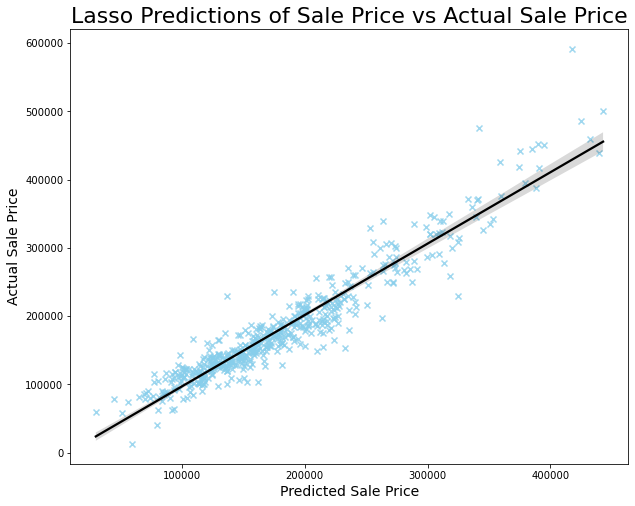

In [40]:
# create scatterplot to show predicted values vs actual values
lasso_preds = lasso.predict(X_test_scaled)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train_scaled, x=lasso_preds, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Lasso Predictions of Sale Price vs Actual Sale Price', fontsize=22)

It's great to see how the model performed in terms of predicted sales price versus actual sales price. We can see that the line of best fit passes through most of the points, barring a couple of outliers in the extreme sales price range.

Text(0.5, 1.0, 'Residuals')

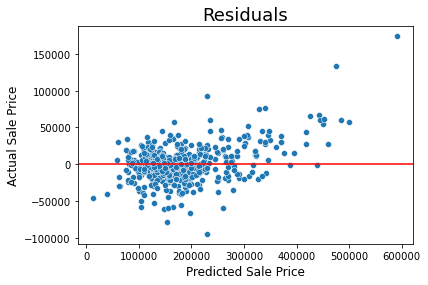

In [41]:
# Residual plot
ax = sns.scatterplot(data=df_train, x=y_test, y= (y_test-lasso_preds))
ax.axhline(y=0, c='red')
plt.xlabel('Predicted Sale Price', fontsize=12)
plt.ylabel('Actual Sale Price', fontsize=12)
plt.title('Residuals', fontsize=18)

In [42]:
# find y_intercept
lasso.fit(X_train_scaled, y_train)
print(lasso.intercept_)

181486.2018229167


Our residuals are mostly equally distributed, which supports the multiple linear regression assumption of homoscedasticity, where the variance of error terms must be similar across the values of the independent variables.

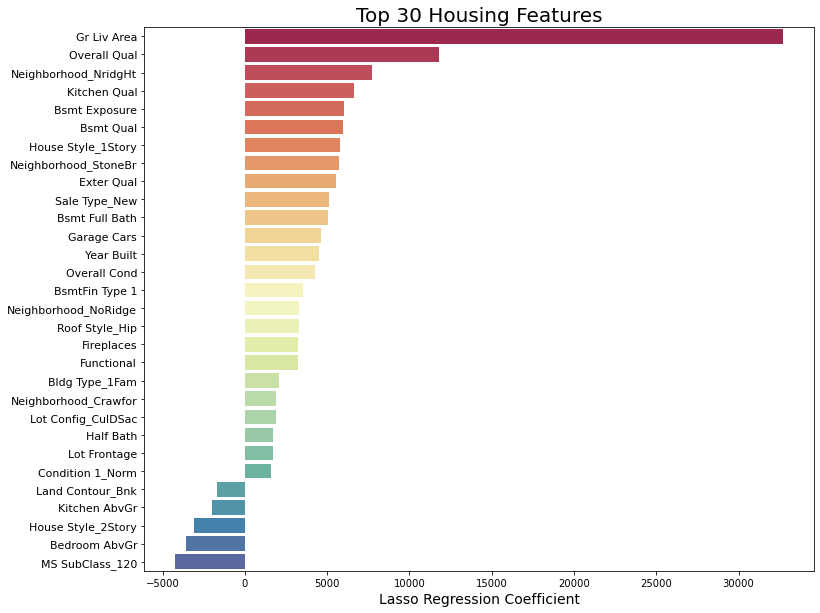

In [43]:
# create dataframe of features, coefficients and absolute coefficients
lasso_df = pd.DataFrame(columns = ['Feature', 'Coef', 'Abs_Coef'])
lasso_df['Feature'] = features
lasso_df['Coef'] = lasso.coef_
lasso_df['Abs_Coef'] = abs(lasso.coef_)

# plot top 30 features (sorted by absolute regression coefficient)
plt.figure(figsize = (12,10))
data = lasso_df.sort_values(by='Abs_Coef', ascending = False).head(30)[['Feature', 'Coef']]\
               .sort_values(by='Coef', ascending = False).reset_index(drop = True)

ax = sns.barplot(data=data, y='Feature', x='Coef', orient='h', palette='Spectral')
ax.set_ylabel('')
ax.set_yticklabels(data['Feature'], size=11)
ax.set_xlabel('Lasso Regression Coefficient', fontsize=14)
plt.title('Top 30 Housing Features', fontsize=20);

In [44]:
# Display top 20 coefficients - Top 15 positive coefficients and bottom 5 negative coefficients
display(data.head(20), data.tail(5))

,Feature,Coef
0,Gr Liv Area,32722.097403
1,Overall Qual,11810.877477
2,Neighborhood_NridgHt,7728.591617
3,Kitchen Qual,6630.330583
4,Bsmt Exposure,5990.683504
5,Bsmt Qual,5960.564240
6,House Style_1Story,5758.596893
7,Neighborhood_StoneBr,5698.704572
8,Exter Qual,5556.516920
9,Sale Type_New,5110.201340


,Feature,Coef
25,Land Contour_Bnk,-1703.529788
26,Kitchen AbvGr,-1994.636773
27,House Style_2Story,-3122.480880
28,Bedroom AbvGr,-3591.514375
29,MS SubClass_120,-4272.607718


The top predictive features for our model seem pretty plausible. Our top features are living area and overall quality, followed by a range of features looking at basement square footage and the quality of the exterior and kitchen. Home functionality and the number of cars that a garage can fit are also important in predicting sale price. Certain neighborhoods like Northridge Heights and Stone Brook also are strong positive predictors.

Conversely, we see that houses that are in `MS SubClass_120` (1 story houses built in 1946 and after, as part of a planned unit development) predict lower prices. The Old Town neighborhood also predicts lower prices, along with certain features such as the number of kitchens or bedrooms above ground. Having two stories also hurts the value of the home.

### Understanding  feature coefficients
Our feature coefficients can be interpreted as β1 in the following linear regression equation: 

$$ Y = \beta_0 + \beta_1 X_1 + \varepsilon$$

Here, β1 represents the estimated slope parameter, which affects the predicted value of Y. In other words, for every 1 unit change in `Gr Liv Area`, our target variable `SalePrice` or Y will increase by \\$32,094. This number is pretty high, which makes it easy for our model to become overfit, as even a slight increase in `Gr Liv Area` will lead to a much larger shift as compared to a 1 unit change for any of our other features.

Our model intercept or β0 is \\$181,486, which suggests that when our predictors are equal to 0, the mean sale price is \\$181,486. This isn't of much use however, as our X will never be 0.

In short, we can interpet our `Gr Liv Area` coefficient's effect on our model as:

$$\hat{\text{SalePrice}} = 181486 + 32094[\text{Gr Liv Area}]$$


### Recommendations
Based on our model, we suggest the below pointers if somone is looking to increase the value of their house:
- Improve the overall and exterior condition and quality of their homes through renovation/ remodelling.
- Improve garage size to allow it to fit more than one car.
- Focus on creating a single indoor kitchen (if they have two kitchens).
- Reduce the number of bedrooms in the house, or renovate existing bedrooms to make them multi-purpose rooms (if the house has more than three bedrooms).

While this model generalizes well to the city of Ames, it's probably not generalizable to other cities, given that each city tends to differ greatly in terms of external factors like geographical features, seasonal weather or the economic climate of that particular city.

Another point to keep in mind that <b>this model doesn't take into account the inflation of housing prices</b>. Since the end of the financial crisis in 2008, housing prices throughout the US have been increasing steadily year over year. Our model would need significant retraining to predict the current house prices in Ames today.

### Model Limiations

#### Tradeoffs between interpretability and accuracy

A key consideration in this project was whether to create a more interpretable model which had a total of 30 or less features. Ultimately, I decided against this as this led to a significant tradeoff in accuracy. Using RFE to select 30 features greatly reduced my model's R2 and RMSE -- I believe that in this case it's not worth trading off model complexity for accuracy, given the model's current performance with about 109 features.

This however does create some limitations. For one, some of the negative predictors are hard to interpret without extensive domain knowledge. For example, on the surface, it doesn't seen logical for the number of kitchens or bedrooms to be negative predictors for price. This can be explained by the fact that these features are acting as a proxy for other features.

For `Kitchen AbvGr`, I realized that houses with two kitchens have a lower mean sale price and were older compared to houses with one kitchen. In Iowa, [summer kitchens](https://www.scottcountyiowa.gov/conservation/pioneer-village/summer-kitchen) were used prior to electricity and air conditioning to keep the heat from cooking out of the house during hot summer months. In colder months, the indoor kitchens was used to help keep the house warm. The fact that houses with two kitchens generally don't have much porch square footage supports this idea (as summer kitchens are generally located on the back porch). This suggests that houses with two kitchens are more likely to be antiquated houses without a good heating/ventilation system.

## Submission

In [45]:
# Refit model on entire training dataset
X_scaled = ss.fit_transform(X)
lasso = LassoCV()
lasso.fit(X_scaled, y)
lasso.score(X_scaled,y)

0.9108962518766032

In [46]:
# Remaining features after zeroing by lasso regression
print('Total Features before Lasso regression:', len(features))
print('Features Zeroed by Lasso regression:', len(lasso.coef_[lasso.coef_ == 0]))
print('Features Remaining after Lasso regression:', len(features) - len(lasso.coef_[lasso.coef_ == 0]))

Total Features before Lasso regression: 121
Features Zeroed by Lasso regression: 12
Features Remaining after Lasso regression: 109


In [47]:
df_test.shape

(878, 121)

In [48]:
final_test_scaled = ss.transform(df_test)

In [49]:
final_predictions = lasso.predict(final_test_scaled)

In [50]:
df_test['SalePrice'] = final_predictions

In [51]:
df_test['Id'] = df_test_ids

In [52]:
# Create csv for submission
submission = df_test[['Id','SalePrice']]
submission.to_csv('./datasets/kaggle_submission.csv', index=False)

#View submission
submission.head()

,Id,SalePrice
0,2658,147572.178099
1,2718,158187.852930
2,2414,224662.036542
3,1989,113359.170977
4,625,180978.002094


## Appendix

Text(0.5, 1.05, 'Regularization versus Standard Linear Regression')

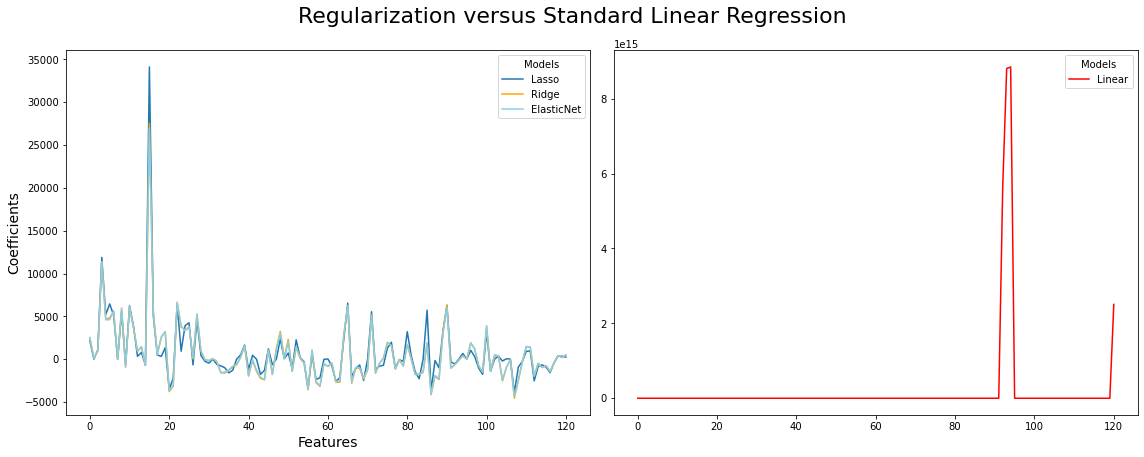

In [53]:
# For reference
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax = ax.ravel()
g = sns.lineplot(data=lasso.coef_, ax=ax[0])
sns.lineplot(data=ridge.coef_, ax=ax[0], color='orange')
sns.lineplot(data=enet.coef_, ax=ax[0],color='skyblue')
g.set_xlabel('Features', fontsize=14)
g.set_ylabel('Coefficients', fontsize=14)
g.legend(title='Models', loc='upper right', labels=['Lasso', 'Ridge', 'ElasticNet'])

g2 = sns.lineplot(data=lr.coef_, ax=ax[1], color='red')
g2.legend(title='Models', loc='upper right', labels=['Linear'])

plt.tight_layout()
plt.suptitle('Regularization versus Standard Linear Regression', fontsize=22, y=1.05)

<AxesSubplot:>

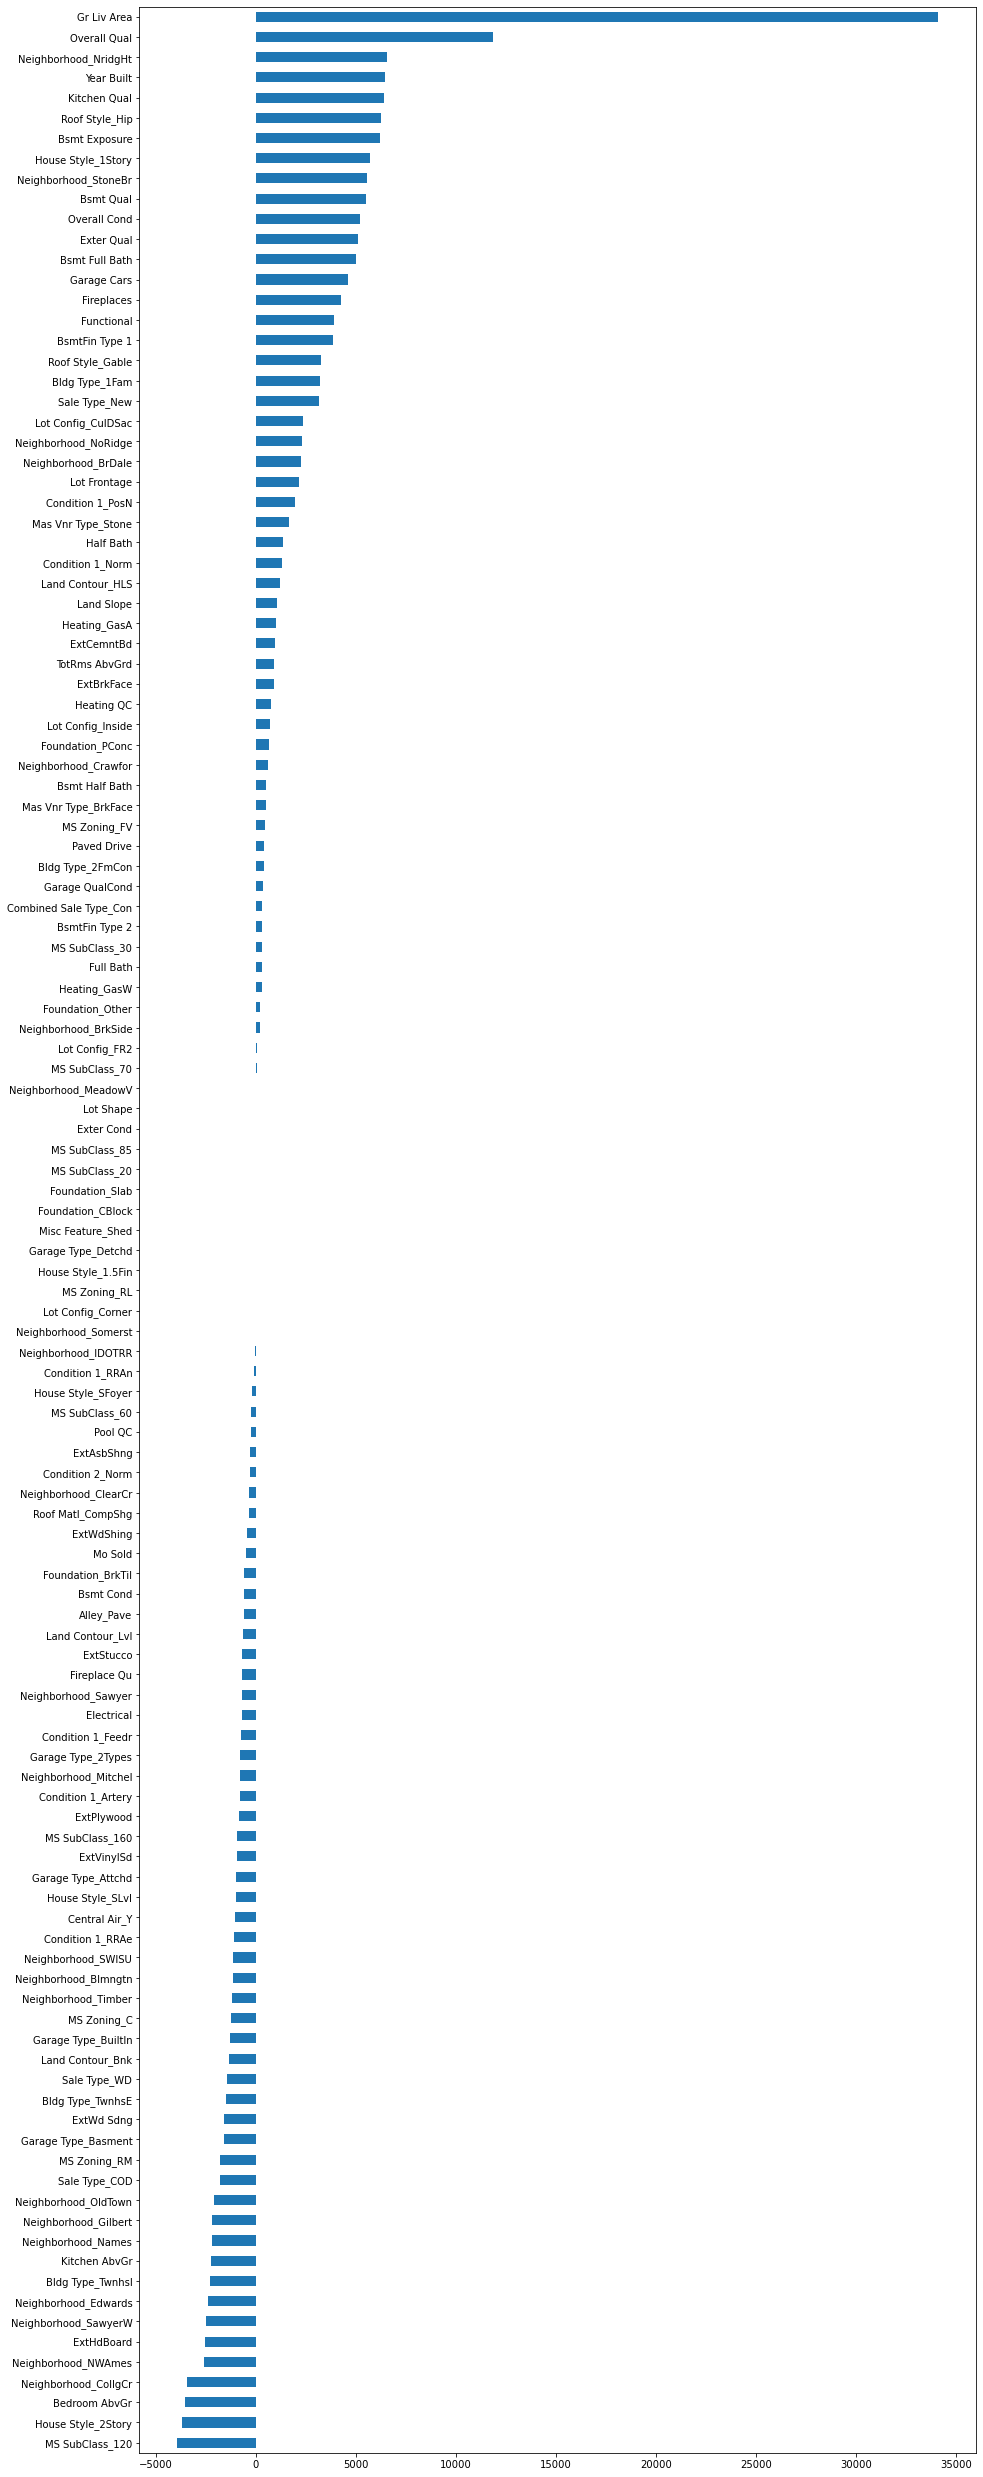

In [54]:
# Full plot of all features and lasso coefficients
pd.Series(lasso.coef_, index=features).sort_values().plot.barh(figsize=(15,45))

Don't forget to create your README!